In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Risque de défaut de crédit

### *Problématique : Prédiction du remboursement d'un crédit de banque* 

Nous avons un dataframe dans lequel sont enregistrées de nombreuses informations sur les clients d'une banque.

La banque veut savoir si elle doit leur accorder un prêt ou non. Le modèle d'apprentissage automatique doit prédire si le client va rembourser le prêt ou non.

Si la cible est égale à 0 : le prêt a été remboursé, si elle est égale à 1 : le prêt n'a pas été remboursé.

Les modèles détermineront si le prêt sera remboursé ou non en fonction des caractéristiques données.

### Objectifs : 
  
  - Précision 70%

  - Minimiser faux positif ( cet à dire les prédictions remboursé qui sont en réalité non rembourser )

# libraries utilisée : 

      numpy, pandas, os, scikit-learn, matplotlib, seaborn

In [2]:
# ---- Cleanup Transform and Modify Data ---- #
import numpy as np
import pandas as pd 

# ---- Operating system ----#
import os

# ---- Data Vizualisation ---- #
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Features enginering ---- #
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer

# ---- Pre processing ---- #
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

# ----- selection features, modèle, param ----- #
 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, StratifiedKFold
!pip install boruta
from boruta import BorutaPy

# ----- Modèle de Machine Learning ----- #
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb

# ---- Métrics ---- # 
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score

     |████████████████████████████████| 56 kB 2.5 MB/s 


liste de fichier csv valide

In [3]:
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/data_ml_banque/"))

['installments_payments.csv', 'credit_card_balance.csv', 'bureau.csv', 'POS_CASH_balance.csv', 'sample_submission.csv', 'HomeCredit_columns_description.csv', 'application_train.csv', 'previous_application.csv', 'bureau_balance.csv', 'application_test.csv']


# Get Data

In [4]:

app = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_ml_banque/application_train.csv')
print('Training data shape: ', app.shape)
app.head(3)

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA ( Exploratory Data Analysis )

### évaluer le nombre de payment et le nombre de difficulté de payment

    - 0 crédit payée
    - 1 crédit non payée

In [5]:
app['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

### Verification des valeurs manquantes

Ensuite, nous pouvons examiner le nombre et le pourcentage de valeurs manquantes dans chaque colonne.


In [6]:
def valeurs_manquantes(df):
        # Totale des valeurs null 
        mis_val = df.isnull().sum()
        
        # Pourcentage des valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Création de table avec les résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename des colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valeurs manquantes', 1 : '% totale des valeurs'})
        
        # Arranger du plus petit au plus grand les pourcentages de valeurs manquantes
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% totale des valeurs', ascending=False).round(1)
        
        # affiche le sommaire des informations 
        print ("Ils y a dans ce dataframe : " + str(df.shape[1]) + " colonne.\n"      
            "Ils y a " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes avec des valeurs manquantes.")
        
        # retourne un dataframe des valeurs manquantes et le pourcentage sur le totalité des valeurs
        return mis_val_table_ren_columns

In [7]:
# statistiques des valeurs manquantes
missing_values = valeurs_manquantes(app)
missing_values.head(5)

Ils y a dans ce dataframe : 122 colonne.
Ils y a 67 colonnes avec des valeurs manquantes.


,Valeurs manquantes,% totale des valeurs
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4


Suppréssion des colonnes avec plus 50% de valeurs manquantes 

In [8]:
print("nombre de colonne avant suppresion")
print(app.shape)
print("nombre de colonne après suppresion")

for items in missing_values.iterrows():

    if items[1]["% totale des valeurs"] > 65:
        app = app.drop(columns = [items[0]])
        
print(app.shape)

nombre de colonne avant suppresion
(307511, 122)
nombre de colonne après suppresion
(307511, 105)


bar plot 

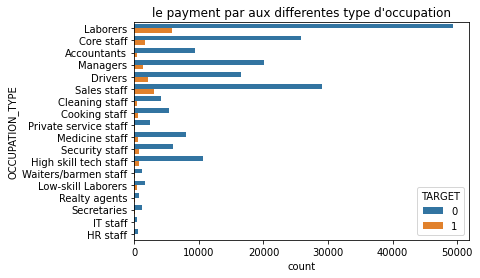

In [9]:
fig = sns.countplot(y="OCCUPATION_TYPE", hue="TARGET", data=app)
plt.title('le payment par aux differentes type d\'occupation')
plt.show()

suppression des plus petites categorie de l'object type d'organisation

In [10]:
for category, value in app['ORGANIZATION_TYPE'].value_counts().items():
    if value < 5000:
        app = app[app.ORGANIZATION_TYPE != str(category) ]


Bar plot des organisation avec le plus gros taux de remboursement de de non remboursé

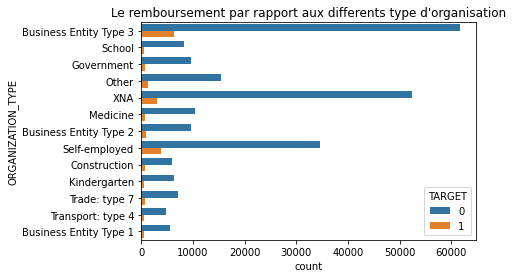

In [11]:
fig = sns.countplot(y="ORGANIZATION_TYPE", hue="TARGET", data=app)
plt.title('Le remboursement par rapport aux differents type d\'organisation')
plt.show()

suppression des colonnes Organisation et occupation type

In [12]:
app = app.drop(columns = ["ORGANIZATION_TYPE"])
app = app.drop(columns = ["OCCUPATION_TYPE"])

vérification du type de chaque colonnes

In [13]:
app.dtypes.value_counts()

float64    49
int64      41
object     13
dtype: int64

Nombre de classe unique dans chaque object du dataframe

In [14]:
app.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE            2
CODE_GENDER                   3
FLAG_OWN_CAR                  2
FLAG_OWN_REALTY               2
NAME_TYPE_SUITE               7
NAME_INCOME_TYPE              8
NAME_EDUCATION_TYPE           5
NAME_FAMILY_STATUS            6
NAME_HOUSING_TYPE             6
WEEKDAY_APPR_PROCESS_START    7
HOUSETYPE_MODE                3
WALLSMATERIAL_MODE            7
EMERGENCYSTATE_MODE           2
dtype: int64

## Analyse des différentes anomalie dans les données

Les chiffres de la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons les multiplier par -1 et les diviser par le nombre de jours dans une année

In [15]:
(app['DAYS_BIRTH'] / -365).describe()

count    252318.000000
mean         44.833546
std          12.122035
min          20.517808
25%          34.775342
50%          44.189041
75%          55.243836
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [16]:
app['DAYS_EMPLOYED'].describe()

count    252318.000000
mean      78334.307802
std      152147.260200
min      -17912.000000
25%       -2599.000000
50%       -1106.000000
75%        -186.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

remplacement des outliers par np.nan

In [17]:
app['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,0.083037,0.262949,...,0.0690,0.0833,0.0375,0.0193,0.00,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,MONDAY,11,0,0,0,0,0,0,0.311267,0.622246,...,0.0345,0.2917,0.0132,0.0558,0.01,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,MONDAY,9,0,0,0,0,0,0,NaN,0.555912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039.0,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,NaN,0.650442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588.0,-4970.0,-477,1,1,1,1,1,0,2.0,2,2,WEDNESDAY,16,0,0,0,0,0,0,NaN,0.354225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2536.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [18]:
app['DAYS_EMPLOYED'].describe()

count    196944.000000
mean      -2334.724622
std        2278.008733
min      -17912.000000
25%       -3107.000000
50%       -1628.000000
75%        -769.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

### corélation

Calcule des corrélations de toutes les colonnes par rapport à la colonnes TARGET


In [19]:
correlations = app.corr()['TARGET'].sort_values()

print('Les plus postives:\n', correlations.tail(15))
print('\n Les plus négatifs:\n', correlations.head(15))

Les plus postives:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032617
LIVE_CITY_NOT_WORK_CITY        0.033288
FLAG_DOCUMENT_3                0.042806
REG_CITY_NOT_LIVE_CITY         0.045275
DAYS_REGISTRATION              0.046134
FLAG_EMP_PHONE                 0.052104
REG_CITY_NOT_WORK_CITY         0.052125
DAYS_ID_PUBLISH                0.053244
DAYS_LAST_PHONE_CHANGE         0.054542
REGION_RATING_CLIENT           0.059268
REGION_RATING_CLIENT_W_CITY    0.060733
DAYS_EMPLOYED                  0.074421
DAYS_BIRTH                     0.082782
TARGET                         1.000000
FLAG_MOBIL                          NaN
Name: TARGET, dtype: float64

 Les plus négatifs:
 EXT_SOURCE_3                 -0.178931
EXT_SOURCE_2                 -0.160894
EXT_SOURCE_1                 -0.159638
FLOORSMAX_AVG                -0.043303
FLOORSMAX_MEDI               -0.042877
FLOORSMAX_MODE               -0.042405
AMT_GOODS_PRICE              -0.037832
REGION_POPULATION_RELATIVE   -0.037282
ELEVATORS_AVG    

### histogramme sur l'age des client 

par tranche de 10 ans 

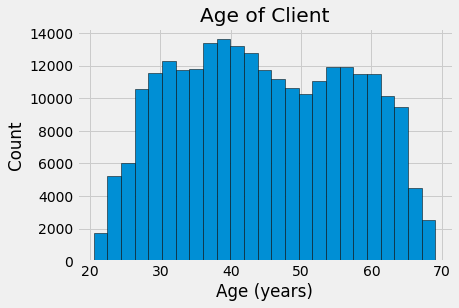

In [20]:
# pour avoir l'age au format positif 
app['DAYS_BIRTH'] = abs(app['DAYS_BIRTH'])

# set style
plt.style.use('fivethirtyeight')

# plot l'age des client en densité 
plt.hist(app['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

### graphique de densité du noyau KDE ( kernel density estimate )

pour observer selon l'âge qui rembourse ou non le crédit

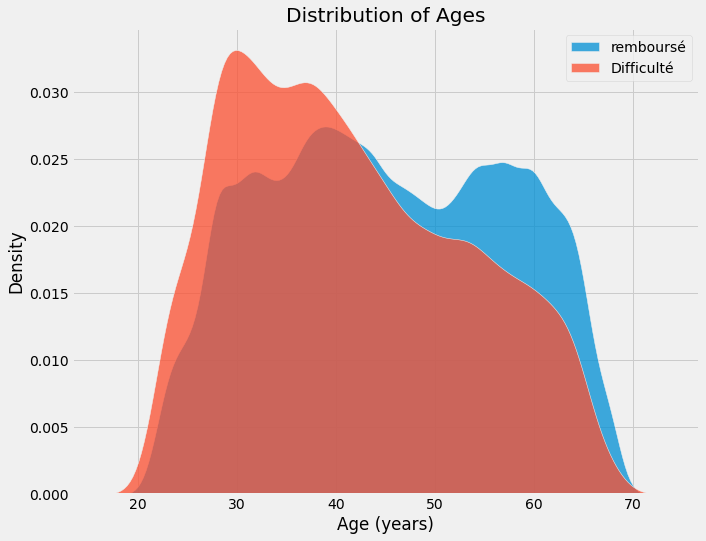

In [21]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app.loc[app['TARGET'] == 0, 'DAYS_BIRTH'] / 365, multiple="stack")

# KDE plot of loans which were not repaid on time
sns.kdeplot(app.loc[app['TARGET'] == 1, 'DAYS_BIRTH'] / 365, multiple="stack")

# Labeling of plot
plt.legend(['remboursé', 'Difficulté'])
plt.xlabel('Age (years)');
plt.ylabel('Density');
plt.title('Distribution of Ages');

## Ségmentation des données 

Avec la fonction cut de la librarie pandas

on segmente l'âge en 5 groupes de min 20 ans à 70 ans  

In [22]:
# on récupere dans un dataframe l'age convertit
age_data = app[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# avec la fonction cut on coupe en carti
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Tout en fesant la moyenne sur les colonnes ( TARGET, DAYS_BIRTH, YEARS_BIRTH )

In [23]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.129313,8541.739425,23.402026
"(25.0, 30.0]",0.114173,10161.384988,27.839411
"(30.0, 35.0]",0.104646,11855.960408,32.482083
"(35.0, 40.0]",0.091772,13710.730155,37.563644
"(40.0, 45.0]",0.080854,15496.587837,42.456405
"(45.0, 50.0]",0.074700,17326.474252,47.469792
"(50.0, 55.0]",0.068225,19201.767223,52.607581
"(55.0, 60.0]",0.055670,20993.109215,57.515368
"(60.0, 65.0]",0.052879,22785.355237,62.425631


### histogramme sur les remboursement en difficulté en fonction de leur groupe d'âge

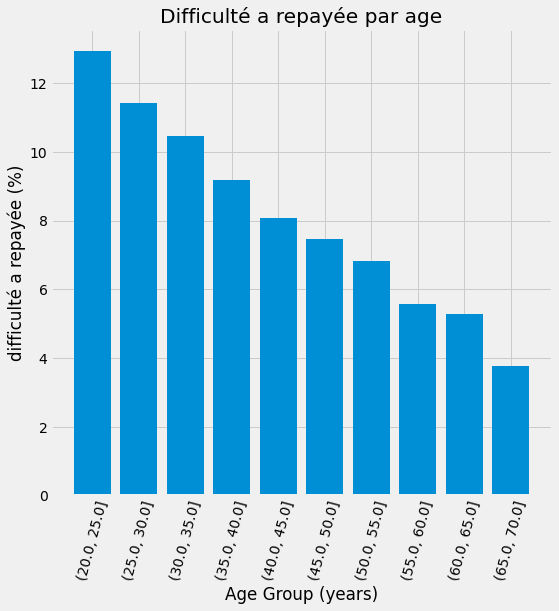

In [24]:
plt.figure(figsize = (8, 8))

plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('difficulté a repayée (%)')
plt.title('Difficulté a repayée par age');

les corrélations avec les colonnes EXT_SOURCE et TARGET

les colonnes EXT_SOURCE sont des score normalisé de différentes source de données externe

In [25]:
# Extraction des colonnes EXT_SOURCE et ces correlations
ext_data = app[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

### Heatmap sur les correlation 

des colonnes ci dessus 

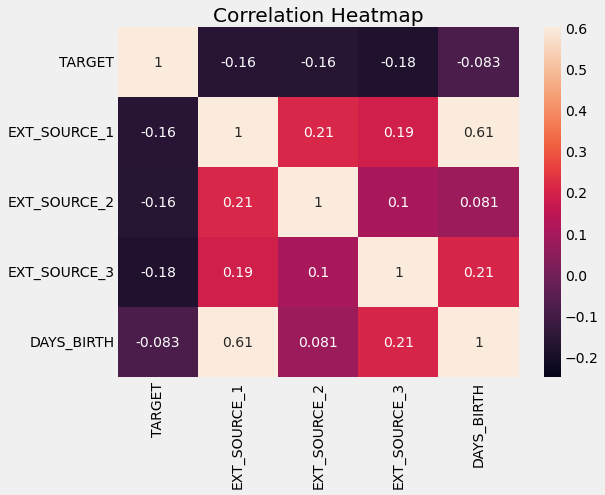

In [26]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Observation des colonnes EXTs par rapport aux remboursement ou au non payé

### graphique de densité du noyau KDE ( kernel density estimate )

pour observer selon les colonnes EXT qui rembourse ou non selon quelle valeur

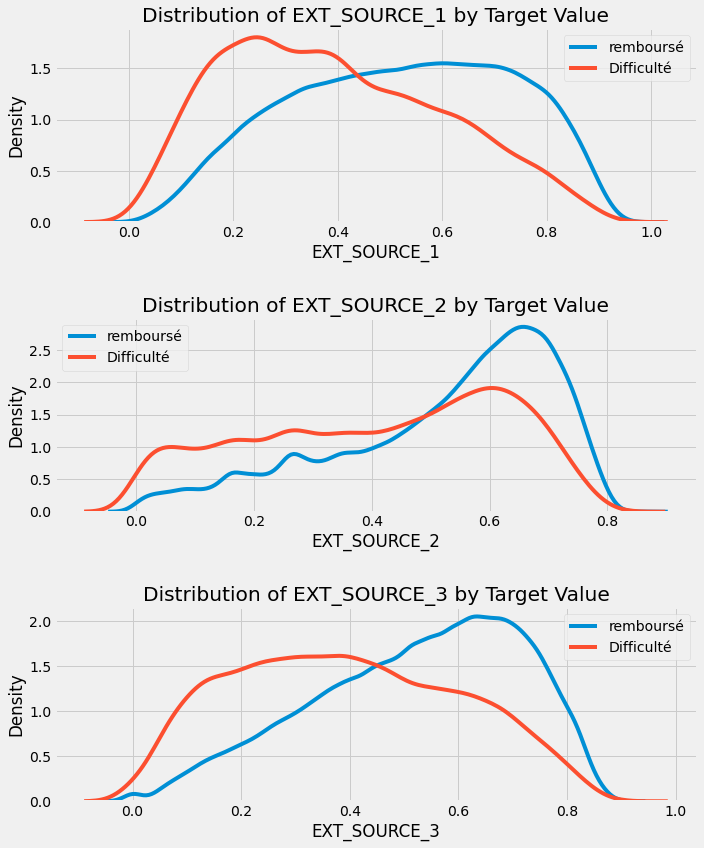

In [27]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app.loc[app['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app.loc[app['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.legend(['remboursé', 'Difficulté'])
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

Création de nouvelle colonnes de pourcentage sur ces 8 colonnes

In [28]:
app_domain = app.copy()

app_domain['CREDIT_INCOME_PERCENT'] = app_domain['AMT_CREDIT'] / app_domain['AMT_INCOME_TOTAL']
app_domain['ANNUITY_INCOME_PERCENT'] = app_domain['AMT_ANNUITY'] / app_domain['AMT_INCOME_TOTAL']
app_domain['CREDIT_TERM'] = app_domain['AMT_ANNUITY'] / app_domain['AMT_CREDIT']
app_domain['DAYS_EMPLOYED_PERCENT'] = app_domain['DAYS_EMPLOYED'] / app_domain['DAYS_BIRTH']

### graphique de densité du noyau KDE ( kernel density estimate )

pour observer selon les colonnes calculé qui rembourse ou non le crédit

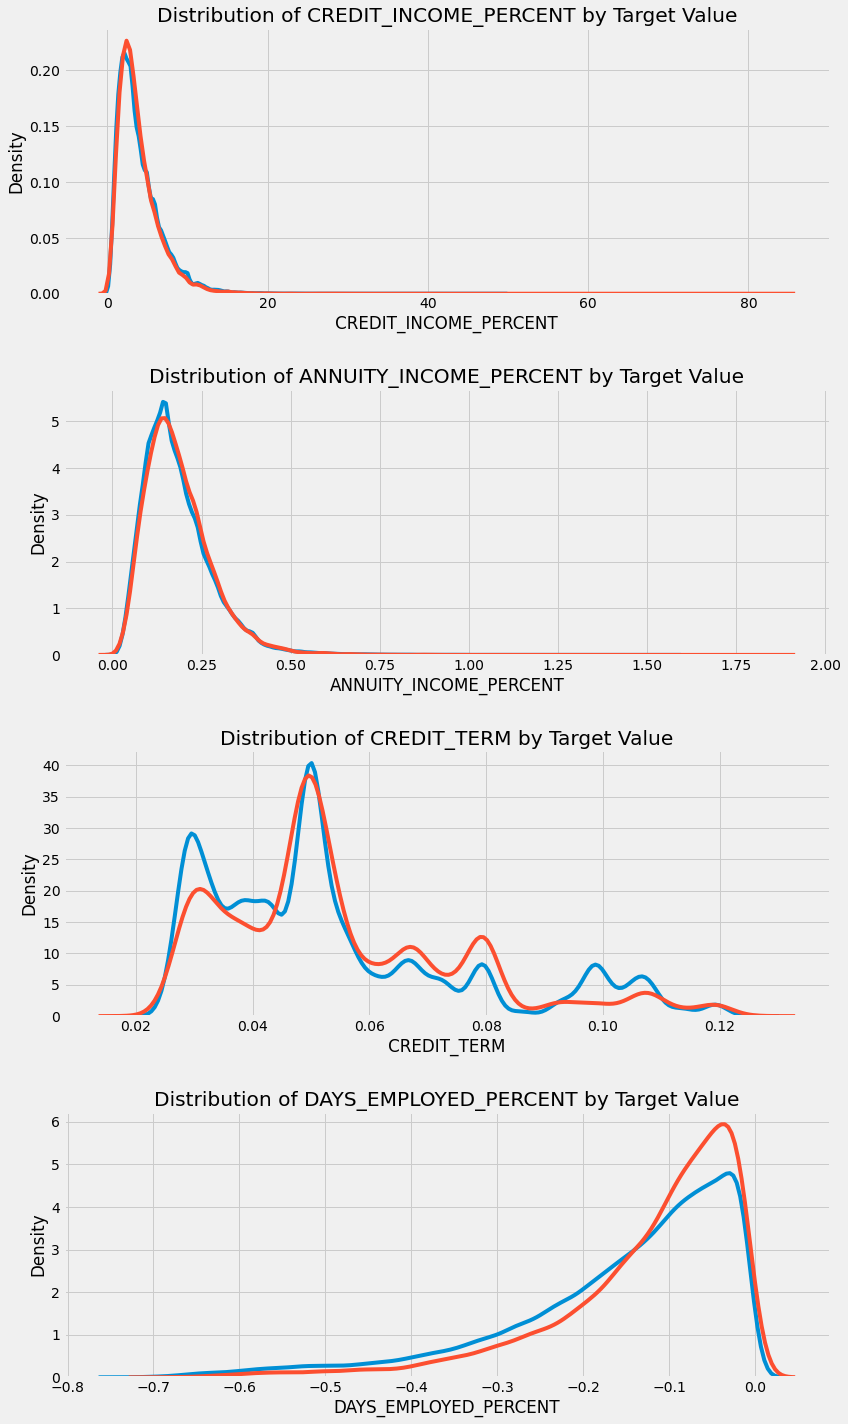

In [29]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    # print(feature) # print du seigneur
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_domain.loc[app_domain['TARGET'] == 0, feature])
    # plot loans that were not repaid
    sns.kdeplot(app_domain.loc[app_domain['TARGET'] == 1, feature])
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Density')
    
plt.tight_layout(h_pad = 2.5)

# Feature enginering

## Encodage des variables de catégorie

Utilisation :

    - le LabelEncoder de Scikit-Learn (Label Encoding) : Attribue un entier à chaque catégorie unique dans une variable catégorielle.
    
    - get_dummies(df) (One-hot Encoding) : Créer une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne pour sa catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes.
    
    - dimensionality reduction : ILs existe plusieurs technique de reduction de dimensionnalités nous ne les utiliserons pas dans ce notebook. 
    
***Dans notres cas nous utiliserons le label Encoding pour toutes les variables catégorielles avec seulement 2 catégories.
Et le One-hot Encoding pour toutes les variables catégorielles avec plus de 2 catégories.***

### Label Encoder

In [30]:
from sklearn.preprocessing import LabelEncoder


# Creer un object 
le = LabelEncoder()
le_count = 0

# iteration sur les colonnes de type object
for col in app:
    if app[col].dtype == 'object':
        # si il y a de classe ou moins par object 
        if len(list(app[col].unique())) <= 2:
            # entrainement 
            le.fit(app[col])
            # Transformation des données
            app[col] = le.transform(app[col])
            
            # pour recuperer le nombre de colonnes encoder
            le_count += 1
            
print('%d colonnes ont était encoder.' % le_count)

3 colonnes ont était encoder.


### One-hot Encoding

In [31]:
# one-hot encoding des variables de categories
app = pd.get_dummies(app)

print('Training Features shape: ', app.shape)

Training Features shape:  (252318, 147)


## Imputation de donnée

    Function SimpleImputer : Transformateur d'imputation pour compléter les valeurs manquantes.

In [32]:
# creation d'un nouveau dataframe avec les polynomial features
poly_features = app[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]

imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Imputation des valeurs manquantes
poly_features = imputer.fit_transform(poly_features)

Function PolynomialFeatures : 

Générez une nouvelle matrice de caractéristiques composée de toutes les combinaisons polynomiales des caractéristiques avec un degré inférieur ou égal au degré spécifié. Par exemple, si un échantillon d'entrée est bidimensionnel et de la forme [a, b], les caractéristiques polynomiales de degré 2 sont [1, a, b, a^2, ab, b^2]. 

In [33]:
# Création de l'objet polymonial avec comme spécification le degrée
poly_transformer = PolynomialFeatures(degree = 3)

make polymonial data training

Total : 35 

In [34]:
# Entrainements des features polynomiales 
poly_transformer.fit(poly_features)

# Transformation des features
poly_features = poly_transformer.transform(poly_features)
print('Taille polymonial des features: ', poly_features.shape)

Taille polymonial des features:  (252318, 35)


Get names of polynomial features 

In [35]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:3]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2']

Observation de la corélation des nouvelles colonnes imputer 

In [36]:
# Création d'un nouveau DataFrame avec les features
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Ajout de la target
poly_features['TARGET'] = poly_target

# Observation des coréalation avec la TARGET
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Afiches les plus positives et les plus négatifs
print(poly_corrs.head(5))
print(poly_corrs.tail(3))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


EXT_SOURCE_3                  -0.000217
EXT_SOURCE_3^2                -0.000087
EXT_SOURCE_3^3                -0.000020
EXT_SOURCE_2 EXT_SOURCE_3^2    0.000536
EXT_SOURCE_2 EXT_SOURCE_3      0.000776
Name: TARGET, dtype: float64
DAYS_BIRTH    0.004797
TARGET        1.000000
1                  NaN
Name: TARGET, dtype: float64


### Merge des dataframe polymonial et d'entrainements

In [37]:

# Merge les features polymoniales avec le dataframe d'entrainements
poly_features['SK_ID_CURR'] = app['SK_ID_CURR']
app_train_poly = app.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# affiche la nouvelle taille du dataframe
print('Nouvelle taille du dataframe d\'entrainements ', app_train_poly.shape)

Nouvelle taille du dataframe d'entrainements  (252318, 183)


## les valeurs sont déséquilibrés  

On doit donc réequilibrer les valeurs de la target de façon : 
A avoir le même nombre de remboursement et de non remboursement.

### Undersampling

In [38]:
X = app
y = np.array(app['TARGET'])
X.drop('TARGET', axis=1, inplace=True)

rus = RandomUnderSampler(random_state=0)
app, y_resampled = rus.fit_resample(X, y)
app['TARGET'] = y_resampled

1    20382
0    20382
Name: TARGET, dtype: int64


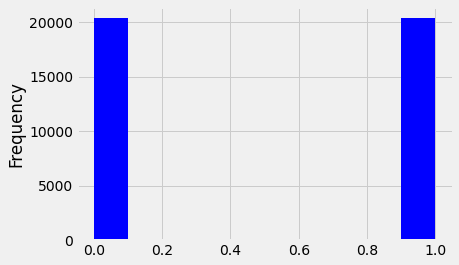

In [39]:
print(app["TARGET"].value_counts())
app["TARGET"].astype(int).plot.hist(color="blue");

## MinMaxScaler 

In [40]:

train_labels = app['TARGET']
# Drop the target from the training data
if 'TARGET' in app:
    train = app.drop(columns = ['TARGET'])
else:
    train = app.copy()
    
# Feature names
features = list(train.columns)


# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)

print('Training data shape: ', train.shape)

Training data shape:  (40764, 146)


# Features selection 

## Boruta

In [41]:
Random_Forest = RandomForestClassifier(n_jobs=-1, max_depth=5)

boruta = BorutaPy(estimator=Random_Forest, n_estimators=20, max_iter=100)
boruta.fit(np.array(train), np.array(train_labels))


BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=20,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7FC4B7DB7050),
         n_estimators=20, random_state=RandomState(MT19937) at 0x7FC4B7DB7050)

In [42]:
# Take a look at relevant the most features 
strong = list()
indexes = np.where(boruta.support_ == True)
for x in np.nditer(indexes):
    strong.append(features[x])
print("Features selections:", strong)
print(len(strong))

Strongly connected features: ['NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'ELEVATORS_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'FLOORSMAX_MODE', 'APARTMENTS_MEDI', 'ELEVATORS_MEDI', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI', 'TOTALAREA_MODE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'CODE_GENDER_F', 'CODE_GENDER_M', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Secondary / secondary special']


# split dataset 

In [43]:
X_train, X_test, y_train, y_test = train_test_split(train, train_labels,random_state=42, test_size = 0.25, stratify=train_labels)

# Machine learning

## LogisticRegression

In [44]:
# Réaliser le modèle avec le paramètre de régularisation C
Logistic_Regression = LogisticRegression(C=0.0001)

# Entrainements des données split
Logistic_Regression.fit(X_train, y_train)


LogisticRegression(C=0.0001)

## Decision Tree

In [45]:
Decision_Tree = DecisionTreeClassifier(criterion='gini')
Decision_Tree.fit(X_train, y_train)

DecisionTreeClassifier()

## Grid Search CV on Random Forest

In [46]:
parameters =  { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

Random_Forest = RandomForestClassifier(random_state=42)

clf_Random_Forest = GridSearchCV(Random_Forest, parameters)
clf_Random_Forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

get best params with this function

In [47]:
clf_Random_Forest.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

## Random Forest

In [48]:
CV_Random_Forest = RandomForestClassifier(max_features='auto', n_estimators= 500, max_depth=8, criterion='entropy')

CV_Random_Forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500)

## XGB boost

In [49]:
xgb_model = xgb.XGBClassifier(objective= 'binary:logistic',
                              nthread=4,
                              use_label_encoder=False,
                              eval_metric='mlogloss')

# Specify tunable parameters and range of values
parameters = {
    'max_depth': range (2,3,1),
    'n_estimators': range(40, 50),
    'learning_rate': [0.1, 0.01, 0.05]
}

clf_xgb = GridSearchCV(xgb_model, parameters, 
                       scoring = 'roc_auc',
                       n_jobs = 5,
                       cv = 5,
                       verbose=True)

clf_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(eval_metric='mlogloss', nthread=4,
                                     use_label_encoder=False),
             n_jobs=5,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 3),
                         'n_estimators': range(40, 50)},
             scoring='roc_auc', verbose=True)

In [50]:
clf_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 49}

In [51]:
 # result of cross validation
 for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
        print(i," : ",clf_xgb.cv_results_[i])

mean_test_score  :  [0.73406527 0.73470792 0.73509657 0.73527408 0.73557944 0.73581432
 0.73637892 0.73683153 0.73686673 0.73725478 0.69671765 0.69677867
 0.69707788 0.69716187 0.69714642 0.69735161 0.69753118 0.69781781
 0.69798542 0.69799611 0.72280954 0.72313889 0.72366262 0.72417808
 0.72470428 0.72510654 0.72556821 0.72584113 0.72620338 0.72658497]
std_test_score  :  [0.00478896 0.00483682 0.00488716 0.00481701 0.0047383  0.00479198
 0.0047816  0.00465548 0.00468131 0.00466835 0.00508822 0.00493235
 0.00481925 0.00486123 0.00493219 0.00478099 0.004704   0.00486334
 0.00484366 0.00476522 0.00497371 0.00491614 0.00486359 0.0046816
 0.00448988 0.00461237 0.0044842  0.00449653 0.00460135 0.00459682]
param_n_estimators  :  [40 41 42 43 44 45 46 47 48 49 40 41 42 43 44 45 46 47 48 49 40 41 42 43
 44 45 46 47 48 49]


# Information Machine Learning

### Prédiction

In [52]:
# Prédiction Logistic Regression
Logistic_Regression_y_pred = Logistic_Regression.predict(X_test)

In [53]:
# Prédiction Decision Tree
Decision_Tree_y_pred = Decision_Tree.predict(X_test)

In [54]:
# Prédiction Random Forest
Random_Forest_y_pred = CV_Random_Forest.predict(X_test)

In [55]:
# Prédiction XGboost
best_xgb = clf_xgb.best_estimator_
xgb_pred = best_xgb.predict(X_test)

### Classification Report

In [56]:
# Classification report Logistic Regression
print("Classification report Logistic Regression")
print(classification_report(y_test, Logistic_Regression_y_pred))

Classification report Logistic Regression
              precision    recall  f1-score   support

           0       0.64      0.63      0.63      5096
           1       0.63      0.64      0.64      5095

    accuracy                           0.64     10191
   macro avg       0.64      0.64      0.64     10191
weighted avg       0.64      0.64      0.64     10191



In [57]:
# Classification report Decision Tree
print("Classification report Decision Tree")
print(classification_report(y_test, Decision_Tree_y_pred))

Classification report Decision Tree
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      5096
           1       0.59      0.59      0.59      5095

    accuracy                           0.59     10191
   macro avg       0.59      0.59      0.59     10191
weighted avg       0.59      0.59      0.59     10191



In [58]:
# Classification report Random Forest
print("Classification report Random Forest")
print(classification_report(y_test, Random_Forest_y_pred))

Classification report Random Forest
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      5096
           1       0.67      0.67      0.67      5095

    accuracy                           0.67     10191
   macro avg       0.67      0.67      0.67     10191
weighted avg       0.67      0.67      0.67     10191



In [59]:
# Classification report XGB
print("Classification report XGB")
print(classification_report(y_test, xgb_pred))

Classification report XGB
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      5096
           1       0.68      0.66      0.67      5095

    accuracy                           0.67     10191
   macro avg       0.67      0.67      0.67     10191
weighted avg       0.67      0.67      0.67     10191



### Accuracy score

In [60]:
# --- Accuracy Logistic Regressions --- #
print(Logistic_Regression.score(train, train_labels))
print("Accuracy score:", round((accuracy_score(y_test, Logistic_Regression_y_pred)*100), 3), '%\n')

0.6283976057305466
Accuracy score: 63.527 %



In [61]:
# --- Accuracy Decision Tree --- #
print(Decision_Tree.score(X_test, y_test))
print("Accuracy score:", round((accuracy_score(y_test, Decision_Tree_y_pred)*100), 3), '%\n')

0.588754783632617
Accuracy score: 58.875 %



In [62]:
# --- Accuracy Random Forest --- #
print(CV_Random_Forest.score(X_test, y_test))
print("Accuracy score:", round((accuracy_score(y_test, Random_Forest_y_pred)*100), 3), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(CV_Random_Forest, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

0.6731429692866254
Accuracy score: 67.314 %

Accuracy score using cross validation: 67.49 %



In [63]:
# --- Accuracy XGBoost --- #
accuracy = accuracy_score(y_test, xgb_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 67.24%


## Data Viz sur les résultats 

### Metrique

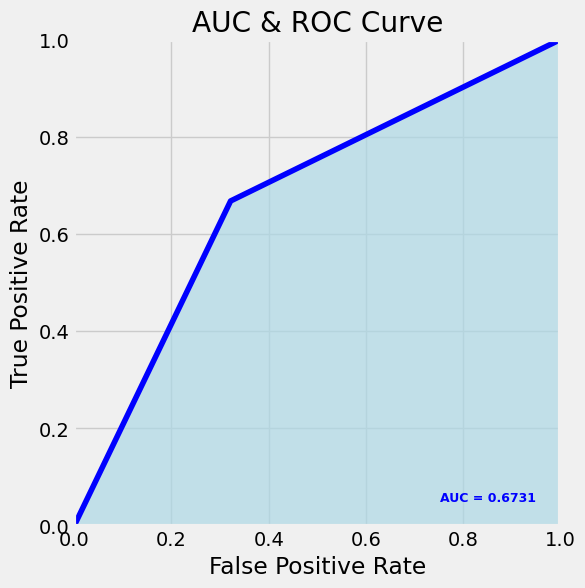

In [64]:
auc_log = metrics.roc_auc_score(y_test, Random_Forest_y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, Random_Forest_y_pred)

plt.figure(figsize=(8, 6), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'b',)
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightblue', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc_log, ha='right', fontsize=9, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Features importances

In [65]:
feature_importance_values = CV_Random_Forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

In [66]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

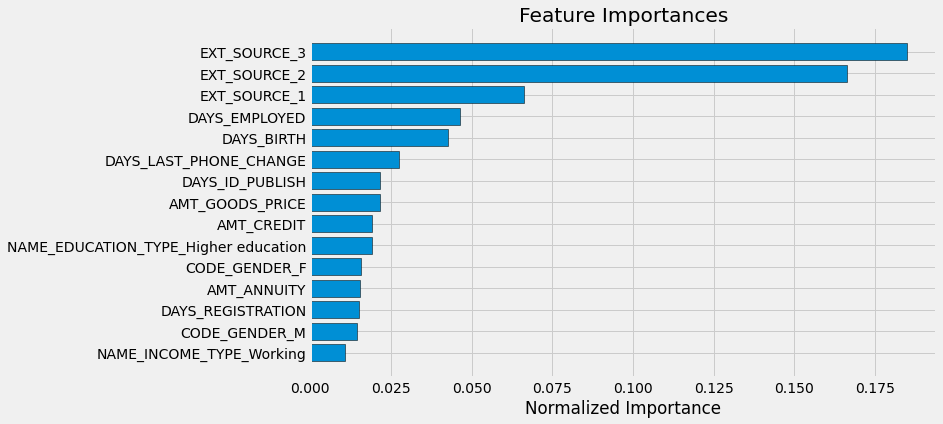

In [67]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

### Matrice de confusion

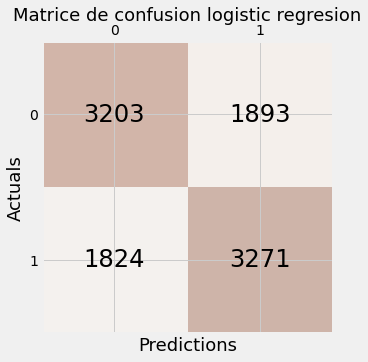

In [68]:
# ---- Matrice de confusion sur le modèle Logistic Regression ---- #
conf_matrix = metrics.confusion_matrix(y_test, Logistic_Regression_y_pred)

fig, ax = plt.subplots(figsize=(5, 5))

ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Matrice de confusion logistic regresion', fontsize=18)
plt.show()

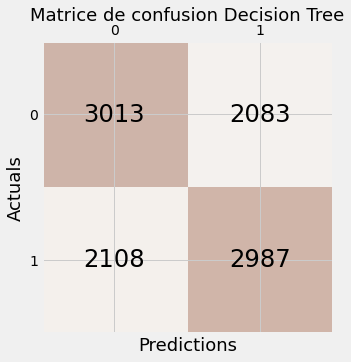

In [69]:
# ---- Matrice de confusion sur le modèle Decision Tree ---- #
conf_matrix = metrics.confusion_matrix(y_test, Decision_Tree_y_pred)

fig, ax = plt.subplots(figsize=(5, 5))

ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Matrice de confusion Decision Tree', fontsize=18)
plt.show()

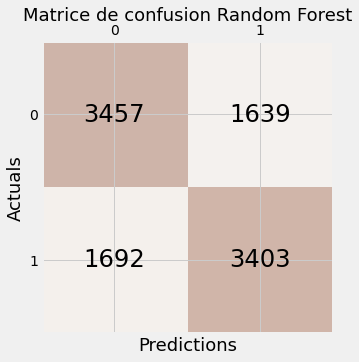

In [70]:
# ---- Matrice de confusion sur le modèle Random Forest ---- #
conf_matrix = metrics.confusion_matrix(y_test, Random_Forest_y_pred)

fig, ax = plt.subplots(figsize=(5, 5))

ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Matrice de confusion Random Forest', fontsize=18)
plt.show()

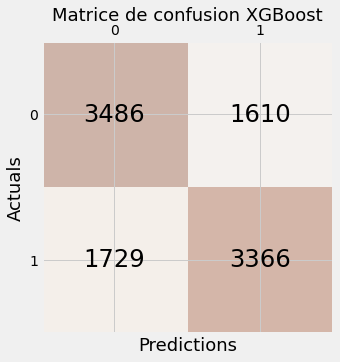

In [71]:
# ---- Matrice de confusion sur le modèle XGBoost ---- #
conf_matrix = metrics.confusion_matrix(y_test, xgb_pred)

fig, ax = plt.subplots(figsize=(5, 5))

ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Matrice de confusion XGBoost', fontsize=18)
plt.show()

## Learning curve

In [72]:
N, train_score, val_score = learning_curve(CV_Random_Forest, 
                                           X_train, 
                                           y_train,
                                           train_sizes = np.linspace(0.1, 1.0, 10),
                                           cv=5)

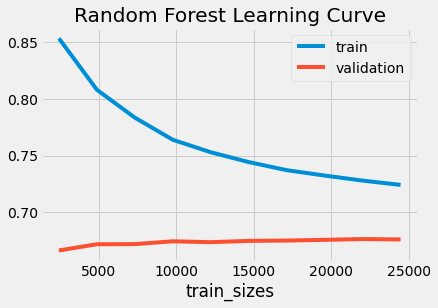

In [73]:
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.title('Random Forest Learning Curve')
plt.show()

# CONCLUSION

Les données fournies étaient très déséquilibrées, nous avons dû utiliser le sous-échantillonnage pour les équilibrer et obtenir des modèles précis. En tant que banque, si le modèle prédit trop de vrais positifs, ce n'est pas un problème. La banque n'accorderait pas le prêt à une personne qui aurait pu le rembourser. Ce n'est pas bon pour les clients et la banque.
Nous observons que le modèle de random forest obtient la meilleur accuracy de 67,51 %